# Introduction to Model Selection

-----

With the growth of machine learning, there is an ever growing list of algorithms that can be used to model data. In previous notebooks, we have introduced many of the most popular machine learning algorithms, including linear and logistic regression, support vector machine, decision trees, k-nearest neighbors, and ensemble techniques like random forest and gradient boosted decision trees. In addition, these algorithms all have their own set of hyperparameters whose values, for optimal performance, must be carefully selected. 

As a result, selecting the best model and associated set of hyperparameters can be a daunting task. In this notebook, we explore the topic of [**Model Selection**][skms] by first manually evaluating one hyperparameter for one machine learning algorithm on a specific data set. This will introduce the basic concepts required to perform model selection, before we move into to more automated techniques. Following this, we will look at grid searches to find the best combinations of multiple hyperparameters. Finally, we will look at additional model selection techniques such as random hyperparameter searches and nested hyperparameter searches. 

While we do not demonstrate them in this notebook, certain algorithms provide [model specific cross-validation][skmscv] hyperparameter searches including linear and logistic regression methods or [out-of-bag estimates][skoob] for hyperparameters such as random forests and gradient boosted decision trees.

-----
[skms]: http://scikit-learn.org/stable/modules/grid_search.html


[skmscv]: http://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation
[skoob]: http://scikit-learn.org/stable/modules/grid_search.html#out-of-bag-estimates

## Table of Contents

[Model Selection](#ModelSelection)

[Grid Search](#Grid-Search)

- [Multi-Dimensional Grid Search](#Multi-Dimensional-Grid-Search)
- [Parameter Grid](#Parameter-Grid)

[Randomized Grid Search](#Randomized-Grid-Search)

[Nested Cross-Validation](#Nested-Cross-Validation)

-----

Before proceeding with the rest of this Notebook, we first have our standard notebook setup code.

-----

In [26]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global fiugure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

# Some cells take a while to run, so we will time them
from time import time

-----

[[Back to TOC]](#Table-of-Contents)

## Model Selection

Formally, model selection is the task of choosing the best machine learning model for a given data set. Thus, to get started, we first need a data set to which we can apply machine learning algorithms. For this purpose we will use the handwritten digit data set that is included with the scikit learn library. This data is comprised of 1,797 eight by eight pixel images, which results in 64 features (or dimensions). The first Code cell below load these data into our feature (`x`) and label(`y`) arrays. 

For the purpose of simplicity, we will use only one machine learning algorithm in this notebook, and focus on finding the best hyperparameters for this one algorithm on these data. The machine learning algorithm we will use to classify these images in this notebook is support vector classification. We also need a scoring method, for support vector classification the default is mean accuracy (i.e., averaged across all classes). However, different (or multiple) [scoring methods][sksm] can be used, adding a further level of complexity to this problem.

This algorithm works best when the data are normalized (or at least scaled to the same ranges). While the individual pixel values are all restricted to the range [0, 16], some pixels are used more than others. For example, the pixels around the outer edges are used less frequently, and thus will likely be distributed differently than the center pixels. As a result, we employ a [`StandardScaling`][skss] estimator as part of a pipeline on these data to normalize all data before applying the SVC estimator.

In this simple example, we will only evaluate one potential hyperparameter (`C`) for this one algorithm. On a real-world problem, however, we likely would evaluate multiple algorithms, each with various hyperparameter combinations in order to determine the best model. We generate an array of eight `C` values for the model selection process spanning 0.001 to 1000. We generate these values in log-space, as this allows us to quickly span a large range of values. Once we have a better idea of the rough range containing the optimal hyperparameter, we can sample the hyperparameter on a finer grid to identify the best hyperparameter value for these data.

-----
[sksm]: http://scikit-learn.org/stable/modules/model_evaluation.html
[skss]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [2]:
import sklearn.datasets as ds

# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Create pipeline of scaler and estimator
svp = Pipeline([('ss', StandardScaler()),
                ('svc', SVC(random_state=23))])

# Create classifier/sample parameter values
c_vals = np.logspace(-3, 4, 8)

print('C values for model selection:\n\n',c_vals)

C values for model selection:

 [  1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00
   1.00000000e+01   1.00000000e+02   1.00000000e+03   1.00000000e+04]


-----

With the data loaded, the machine learning pipeline created, and a grid of hyperparameters specified, we can now proceed evaluating the different models. The first step is to generate a training and testing data sample, in this case we use 75% of the data for training, and we also employ a stratified splitting to preserve the class representation in both the training and testing data sets. For this task, there are ten classes, so we want to ensure the classes are fairly represented in the training and testing to minimize any potential biases that might result from an artificial class imbalance.

-----

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size = 0.25, 
                     stratify=y, random_state=23)

-----

The next step is to create a cross-validation iterator that will be applied to the training data to evaluate the model hyperparameters. In this case, we employ a stratified k-fold cross-validation technique to once again maintain class balance. We also specify five folds (via the `n_splits` parameter), which will produce five unique training and validation data sets for each hyperparameter. 

-----

In [5]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=23)

-----

We now can compute cross validation scores for the different combinations of our two hyperparameters. The easiest way to accomplish this goal is to use the [`cross_val_score`][skcvs] function, which applies an estimator, with a cross-validation technique to a training data set. This function will compute and return an array of scores for each fold in the cross-validation, by default three-fold cross-validation is used. The scores are computed using the default score method for the provided estimator, such as `accuracy`, but different metrics can be supplied via the `scoring` hyperparameter.

The following Code cell applies this function to the handwritten image data set. First, we start a clock to compute the time for the cross-validation to complete. Next, we create two empty arrays to hold the statistics for the cross-validation scores (we will compute the mean and standard deviation). Next, we iterate through each value in our array of hyperparameter values, compute the cross-validation scores, and compute the statistics of these cross-validation scores. Finally, we display the total time taken for this specific cross-validation.

-----
[skcvs]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [6]:
from sklearn.model_selection import cross_val_score

# Start clock
start = time()

# Create arrays to hold cross-validation statistics
scr_mean = np.zeros(c_vals.shape)
scr_std = np.zeros(c_vals.shape)

# Loop over parameter values to accumulate statistics
for idx, c in enumerate(c_vals):
    svp.set_params(svc__C = c)
    score = cross_val_score(svp, x_train, y_train, cv=skf)
    scr_mean[idx] = np.mean(score)
    scr_std[idx] = np.std(score)

# Display compute time
print(f'Compute time = {time() - start:4.2f} seconds.')

Compute time = 6.61 seconds.


-----

With the mean and standard deviation compute for the scores determined during each cross-validation, we can find the model that had the best score. To do this, we find the index into the mean score array, by using the `argmax` function from the NumPy library. This allows us to display the best model score and the best model hyperparameter, as shown in the following Code cell.

-----

In [7]:
# Find best score (from means of scores)
idx = np.argmax(scr_mean)

# Display best score (and error) and associated 'C' value
print(f'Best Score = {scr_mean[idx]:5.3f} +/- {scr_std[idx]:5.3f}')
print(f'Best C param = {c_vals[idx]:5.3f}')

Best Score = 0.981 +/- 0.002
Best C param = 10.000


-----

With the hyperparameter that determined the best scoring model, we can perform standard model performance testing by creating and applying this model to the test data. In the following Code cell, we create an SVC model with the best `C` hyperparameter, train this model on the training data, and finally apply it to the test data. Finally, these predictions are used to generate a classification report, which indicates the strong performance of this best scoring model.


-----

In [8]:
from sklearn.metrics import classification_report

# Set hyperparemeter to best value
svp.set_params(svc__C = c_vals[idx])

# Train model and predict on test data
svp.fit(x_train, y_train)
y_pred = svp.predict(x_test)

# Generate classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        45
          1       1.00      1.00      1.00        46
          2       1.00      1.00      1.00        44
          3       1.00      1.00      1.00        46
          4       0.98      1.00      0.99        45
          5       1.00      0.98      0.99        46
          6       0.98      1.00      0.99        45
          7       0.98      0.98      0.98        45
          8       0.98      1.00      0.99        43
          9       0.98      0.93      0.95        45

avg / total       0.99      0.99      0.99       450



-----

We also can visualize the model scores for different hyperparameter values. The following Code cell plots the confidence interval ( or, in this case, the mean plus or minus one standard deviation) for the model score for different values of the `C` hyperparameter. To complete this, the Code cell uses two Matplotlib functions: `semilogx` and `fill_between`. The former plots the data by using logarithmic spacing on the x axis, and standard linear spacing on the y axis. The latter fills the space between the `high` and `low` regions.

From this plot, we see that low values for `C` perform poorly, but that once the `C` value exceeds 0.1, the scores increase dramatically, and become nearly constant above zero. Thus, to determine the best model to these data, we will need to explore additional hyperparameter in addition to the `C` value.

-----

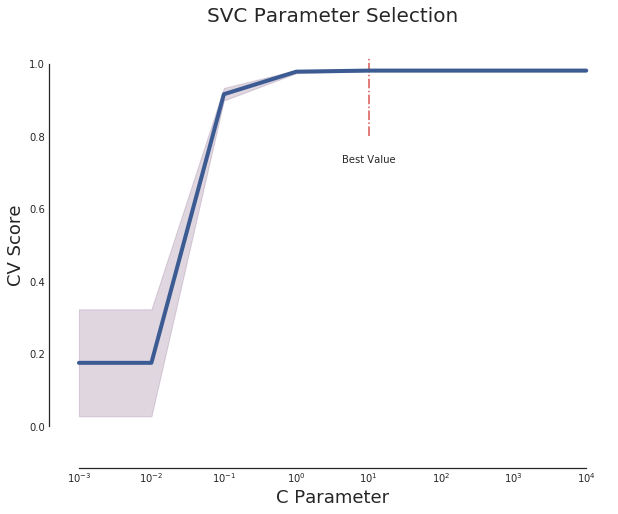

In [9]:
# Define confidence interval
high = scr_mean + scr_std
low = scr_mean - scr_std

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

# Plot confidence interval
ax.semilogx(c_vals, scr_mean, 
            color=sns.xkcd_rgb["denim blue"], linewidth=4)
ax.fill_between(c_vals, high, low, 
                color=sns.xkcd_rgb["dusty purple"], alpha=0.25)

# Mark the best `C` value
ax.vlines(c_vals[idx], 0.8, 1.02, linestyles='-.', 
          color=sns.xkcd_rgb["pale red"])
ax.text(c_vals[idx], 0.75, 'Best Value', 
        horizontalalignment='center', 
        verticalalignment='top')

# Decorate plot
ax.set(title='SVC Parameter Selection',
        xlabel='C Parameter', 
        ylabel='CV Score', ylim=(-0.1, 1.1))
    
ax.legend(loc=4, borderaxespad=1.5)
sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we applied cross-validation using a support vector classification estimator to the handwritten digit data set to determine the best `C` hyperparameter. Now that you have seen this technique work, try making the following changes and see if you can explain the results.

2. Change the example to compute the best value of the _gamma_ hyperparameter.
3. Change the algorithm to use a random forest classifier, and vary the `max_features` hyperparameter.

-----

[[Back to TOC]](#Table-of-Contents)

## Grid Search

Many machine learning algorithms have parameters that can be adjusted to
tune the performance of the algorithm on a particular data set, for
example, the `C` parameter in SVM. While in some cases there is a
theoretical justification for a particular parameter value when applied
to a specific data set, in many cases, we must determine the parameter
(sometimes called hyper-parameter) values programmatically. With
multiple parameters, however, this process can quickly become tedious,
e.g., when running DBSCAN and changing the `eps` and `min_samples`
parameters.

Rather than repeatedly manually changing parameter values and computing
the resulting model scores, a better approach is to employ a grid search
approach. In a grid search, one defines a grid of parameter values,
applies the model over all possible parameter value combinations in the
grid, and identifies the set of parameters that produces the best model
performance score. The scikit learn library provides a
[`GridSearchCV`][skgs] object that performs a grid search by using cross
validation, which produces a model score at the end.

In the following code cell, we demonstrate using `GridSearchCV` to
compute the best value for the `C` parameter when running the SVC
algorithm on the Handwritten Digit data. In this simple case, we simply
employ the estimator directly, however, a grid search is often most
effective when analyzing a pipeline that can have many free parameters.

-----
[skgs]: http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

In [10]:
from sklearn.model_selection import GridSearchCV

# Start clock
start = time()

# Create a dictionary of hyperparameters and values
params = dict(svc__C=c_vals)

# Create grid search cross validator
gse = GridSearchCV(estimator=svp, param_grid=params, cv=skf)

# Fit estimator
gse.fit(x_train, y_train)

# Display time and best estimator results.
print(f'Compute time = {time() - start:4.2f} seconds.\n')

print(f'Best C={gse.best_estimator_.get_params()["svc__C"]:5.4f}')
print(f'Best CV Score = {gse.best_score_:4.3f}')

Compute time = 10.44 seconds.

Best C=10.0000
Best CV Score = 0.981


-----

The grid search cross-validation estimator also provides access to the underlying best model, which allows us to make predictions. In the following Code cell, we compute the prediction score for the best model on our test data. In this case, the results are quite good, indicating that our _best model_ appears robust.

-----

In [11]:
print(f'Test Score = {gse.score(x_test, y_test):4.3f}')

Test Score = 0.989


-----

The grid search cross-validation estimator stores the cross validation results, which can be accessed as a dictionary of NumPy arrays. In the following three Code cells, we demonstrate accessing several of these arrays. First, we extract the mean fit times for each cross-validation, and compute and display the mean and total time. Next, we extract the mean training score, and find and display the maximum training score. Finally, we extract the mean test score (from each validation pass), and  find and display the maximum mean test score. More information on the different arrays that can be extracted is available in the online documentation for the [`GridSearchCV`][skgscv] estimator.

-----

[skgscv]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [12]:
# Extract and process the mean fit time
mft = gse.cv_results_['mean_fit_time']

print(f'Mean fit time = {np.mean(mft):5.3f} +/- {np.std(mft):5.3f}')
print(f'Total fit time = {np.sum(mft):4.2f} seconds')

Mean fit time = 0.139 +/- 0.077
Total fit time = 1.11 seconds


In [13]:
# Extract and process the mean training score

mft = gse.cv_results_['mean_train_score']

print(f'Best train score = {np.max(mft):5.3f}')

Best train score = 1.000


In [14]:
# Extract and process the mean test score

mft = gse.cv_results_['mean_test_score']

print(f'Best test score = {np.max(mft):5.3f}')

Best test score = 0.981


-----

Given the array of mean test scores, we can find the index in this array  for the highest score. This index can be used to find the hyperparameter that generated this score by extracting the NumPy array containing the `C` values, which is `param_svc__C`. The following Code demonstrates this process by using the NumPy `argmax` function to find the index for the maximum test score, and using this index to find and display the corresponding `C` value.


-----

In [15]:
gs_idx = np.argmax(gse.cv_results_['mean_test_score'])
print(f'Best C value = {gse.cv_results_["param_svc__C"][gs_idx]}')

Best C value = 10.0


-----

For easier access to the data, we can transform the dictionary of arrays  returned by the grid search cross-validation estimator into a DataFrame. This provides additional functionality, including improved display of the results, as well as transformations provided by the Pandas module. In the following Code cell, we convert the `cv_results_` to a DataFrame, and display the _transpose_ (this just flips the columns to rows and vice versa), which makes the results easier to explore. In this view, the columns are now different cross-validation folds, we had seven different values for `C` in the grid search so there are seven columns. The rows are the different pre-computed quantities, include the `mean_fit_time`, `mean_train_score`, and `param_svc__C`.

-----

In [16]:
# Convert results to a DataFrame
gse_df = pd.DataFrame(gse.cv_results_)

# Transpose is easier to view (columns become CV results)
gse_df.T

,0,1,2,3,4,5,6,7
mean_fit_time,0.263845,0.263719,0.167492,0.0869765,0.0829941,0.0830562,0.0831083,0.0829695
mean_score_time,0.0337484,0.0339588,0.0300363,0.0192843,0.0181428,0.018206,0.0181434,0.0181471
mean_test_score,0.175204,0.175204,0.91611,0.978471,0.98144,0.98144,0.98144,0.98144
mean_train_score,0.179702,0.179702,0.944131,0.996659,1,1,1,1
param_svc__C,0.001,0.01,0.1,1,10,100,1000,10000
params,{'svc__C': 0.001},{'svc__C': 0.01},{'svc__C': 0.1},{'svc__C': 1.0},{'svc__C': 10.0},{'svc__C': 100.0},{'svc__C': 1000.0},{'svc__C': 10000.0}
rank_test_score,7,7,6,5,1,1,1,1
split0_test_score,0.101818,0.101818,0.898182,0.974545,0.981818,0.981818,0.981818,0.981818
split0_train_score,0.101679,0.101679,0.941231,0.996269,1,1,1,1
split1_test_score,0.47037,0.47037,0.907407,0.977778,0.981481,0.981481,0.981481,0.981481


-----

[[Back to TOC]](#Table-of-Contents)

### Multi-Dimensional Grid Search

The previous example performed a grid search on one hyperparameter. This approach can be extended to multiple hyperparameters by constructing a dictionary that maps the hyperparameters to the hyperparameter values. In the following Code cell, we demonstrate this by first creating arrays of our hyperparameter values, for both the `C` and `gamma` values. Next, we construct the grid of `C` and `gamma` values for the SVC algorithm by using an explicit dictionary. This grid has 48 (6 x 8) values, over which we perform stratified k-fold cross-validation using our SVC pipeline. At the end of the Code cell, we compute and display the processing time, the best fit hyperparameters, and the best cross-validation score.

-----

In [17]:
# Start clock
start = time()

# Define individual parameter values
# Equal-spaced intervals in log-space
c_vals = np.logspace(-2, 3, 6)
g_vals = np.logspace(-7, 0, 8)

# Create parameter grid, by using an explicit dictionary
params = dict(svc__C=c_vals, svc__gamma=g_vals)

# Create Grid Search Cross validation iterator
mgse = GridSearchCV(estimator=svp,
                    param_grid=params,
                    cv=skf)

# Fit and display results of grid search
mgse.fit(x_train, y_train)

# Compute and display results
print(f'Compute time = {time() - start:4.2f} seconds.\n')

mgbe = mgse.best_estimator_
print(f'Best C={mgbe.get_params()["svc__C"]:5.4f}')
print(f'Best gamma={mgbe.get_params()["svc__gamma"]:5.4f}')
print(f'Best CV Score = {mgse.best_score_:4.3f}')

Compute time = 87.23 seconds.

Best C=100.0000
Best gamma=0.0100
Best CV Score = 0.984


-----

We can convert the cross-validation results into a Pandas DataFrame to simplify access and analysis. As the following Code cell demonstrates, we can convert the multiple hyperparameter grid search results into a DataFrame and quickly compute descriptive statistics for the relevant columns.

-----

In [18]:
# Convert results to a DataFrame
df = pd.DataFrame(mgse.cv_results_)

# Generate descriptive statistics
df.describe()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.217462,0.029124,0.518158,0.605546,22.833333,0.492273,0.577056,0.615972,0.717444,0.492643,0.576975,0.490559,0.578414,0.499138,0.577841,0.001750,0.000430,0.054650,0.056569
std,0.099090,0.007157,0.378686,0.386502,12.958745,0.398570,0.417842,0.295341,0.265482,0.405191,0.417956,0.400978,0.418310,0.407661,0.417269,0.000725,0.000254,0.058282,0.065699
min,0.044835,0.012413,0.108389,0.160389,1.000000,0.101818,0.101679,0.137037,0.394615,0.100372,0.102041,0.101124,0.101852,0.101504,0.101758,0.000560,0.000154,0.003748,0.000000
25%,0.118194,0.028555,0.167780,0.167631,12.500000,0.101818,0.101679,0.433333,0.430826,0.100372,0.102041,0.101124,0.101852,0.101504,0.101758,0.001326,0.000292,0.008626,0.000000
50%,0.260433,0.033456,0.402376,0.565042,24.500000,0.398182,0.554104,0.505556,0.583101,0.375465,0.555659,0.406367,0.567130,0.400376,0.565217,0.001611,0.000337,0.016109,0.010358
75%,0.264171,0.033680,0.943022,1.000000,30.000000,0.938182,1.000000,0.937037,1.000000,0.947955,1.000000,0.937266,1.000000,0.958647,1.000000,0.002094,0.000502,0.132962,0.131598
max,0.371649,0.034242,0.983667,1.000000,47.000000,0.981818,1.000000,0.985185,1.000000,0.988848,1.000000,0.981273,1.000000,0.992481,1.000000,0.003775,0.001548,0.152237,0.161681


-----

Another benefit of creating a DataFrame from the cross-validation results is that we can employ the Pandas DataFrame support to create insight into the process. For example, the next two Code cells first create a pivot table on the hyperparameters where the value is the mean test score. This pivot table is converted into a heat map in the second Code cell, which demonstrates the joint impact of these hyperparameters on the score from the validation data. In this case, we see the previous relatively constant scoring once the `C` value exceeds zero is actually dependent on the value of `gamma`. Thus, this demonstrates how the joint score distribution from all hyperparameters is needed to find the best model.

-----

In [19]:
# Create pivot table of scores for grid parameters
pvt = df.pivot('param_svc__C', 'param_svc__gamma', 'mean_test_score')

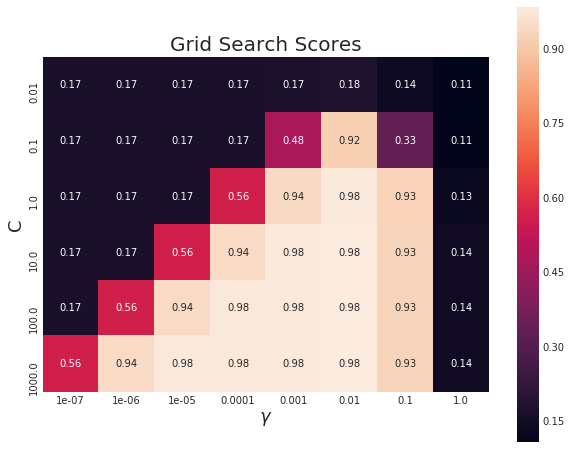

In [20]:
# Create figure
fig, axs = plt.subplots(figsize=(10,8))

# Generate heatmap of scores
axs = sns.heatmap(pvt, annot=True, square=True, ax=axs)

# Decorate plot
axs.set(title='Grid Search Scores', xlabel='$\gamma$', ylabel='C') ;

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we created a DataFrame from a grid search cross-validation using the SVC algorithm on the handwritten digit data set. Try making the following changes to the previous example and see if you can understand the results.

2. The grid used in the previous example was rather course, try changing the number and locations of grid points in order to determine the best hyperparameter combination for the `C` and `gamma` hyperparameters. 
3. Try changing to a different classification algorithm such as the random forest classifier, and find the best hyperparameters combinations. Make a heatmap from two of the hyperparameters.

-----

We also can specify multiple grids, by creating a list of hyperparameter dictionaries. This can be used to explore combinations of hyperparameters that are not all of the same dimension. For example, if the SVC algorithm uses the _rbf_ kernel, we can test both the `C` and `gamma` hyperparameter. However, if the SVC algorithm uses the _linear_ kernel, we can only test the `C` hyperparameter. In this manner, we can construct multiple grids to evaluate all possible hyperparameter combinations, and determine the best set of hyperparameters for a given data set. 

We demonstrate this in the following Code cell, where we create two separate hyperparameter grids, one for a _linear_ SVC kernel and one for the _rbf_ SVC kernel. The rest of the code is the same as before, and we determine and display the best hyperparameters, the best score, and the compute time.

-----

In [21]:
# Start clock
start = time()

# Define two hyperparameter grids
# one for linear kernel and one for rbf kernel
params = list((dict(svc__kernel=['rbf'], 
                    svc__C=c_vals, 
                    svc__gamma=g_vals),
              dict(svc__kernel=['linear'], 
                   svc__C=c_vals)))

# Create grid search CV
tgse = GridSearchCV(estimator=svp,
                    param_grid=params,
                    cv=skf)

# Fit cross validation estimator
tgse.fit(x_train, y_train)

# Compute and display results
print(f'Compute time = {time() - start:4.2f} seconds.\n')

tgbe = tgse.best_estimator_
print(f'Best C={tgbe.get_params()["svc__C"]:5.4f}')
print(f'Best gamma={tgbe.get_params()["svc__gamma"]:5.4f}')
print(f'Best gamma={tgbe.get_params()["svc__kernel"]}')

print(f'Best CV Score = {tgse.best_score_:4.3f}')

Compute time = 89.45 seconds.

Best C=100.0000
Best gamma=0.0100
Best gamma=rbf
Best CV Score = 0.984


-----

[[Back to TOC]](#Table-of-Contents)

### Parameter Grid

When dealing with many hyperparameters, it can be challenging to track all combinations. A better approach is a programmatic interface that automatically constructs a grid of all possible combinations that can be used in a grid search. The scikit learn library provides this interface through the [`ParameterGrid`][skpg] iterator. This iterator enables the grid search to iterate through all possible hyperparameter combinations in a simple manner. 

The following Code cell demonstrates how to use this iterator. First, we create the iterator by passing in our parameter dictionary. In this case, we have forty-eight grid points: eight values for $\gamma$ and six values for `C`. Next, we select one grid point and extract the dictionary of hyperparameters and their values for display.

-----

[skpg]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html

In [22]:
from sklearn.model_selection import ParameterGrid

# Create the parameter grid
pg = ParameterGrid(params)

# Display results from the parameter grid
print(f'Number of grid points = {len(pg)}\n')

# Each point in grid has a dictionary of hyperparameters
print(f'First grid hyperameter values:')
for k, v in pg[0].items():
    print(f'    Parameter: {k} = {v}')

Number of grid points = 54

First grid hyperameter values:
    Parameter: svc__kernel = rbf
    Parameter: svc__gamma = 1e-07
    Parameter: svc__C = 0.01


-----

[[Back to TOC]](#Table-of-Contents)

## Randomized Grid Search

For a large number of hyperparameters, the number of possible combinations quickly becomes excessive. Since we must evaluate the model for each possible combination of parameters, model selection with standard grid selection can become computationally intractable. An alternative approach is to randomly select possible hyperparameter combinations from the supplied grid of values to identify good parameter combinations.

In the following Code cell, we demonstrate random grid search by using the [`RandomizedSearchCV`][skrgs] estimator. First, we pass in our support vector machine pipeline, along with the parameter grid, and the number of parameter values to sample. As this last value increases, more parameter value combinations are sampled. These values are sampled randomly from a distribution for each parameter. If a list of values is provided (as we have done with previous grid searches), the values are randomly sampled from the list. Alternatively, a random distribution can be used. The requirement for these distributions is that they must contain an `rvs` method, which is provided by the random distributions in the `scipy.stats` module. 

We demonstrate both of these techniques in the example below, which compute scores for twenty different parameter combinations. In the second Code cell, we extract the best estimator and display the optimal parameters and associated score. Note that, while not the guaranteed best score (and hyperparameter values), the value is close. Thus, the random search cross-validation can be useful to get reasonable hyperparameters values much faster than with traditional techniques.

-----

[skrgs]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import  scipy.stats as st

# Start clock
start = time()

# Number of random parameter samples
num_samples = 20

# Create parameter grid, by using explicit dictionary
pd = {'svc__C': st.uniform(0, 250),
      'svc__gamma': g_vals}
 
# Run randomized search
rscv = RandomizedSearchCV(svp, param_distributions=pd,
                          n_iter=num_samples)

# Fit grid search estimator and display results
rscv.fit(x_train, y_train)
print(f'Compute time = {time() - start:4.2f} seconds', end='')
print(f' for {num_samples} parameter combinations')

Compute time = 13.67 seconds for 20 parameter combinations


In [24]:
# Get best esimtator
be = rscv.best_estimator_

# Display parameter values
print(f'Best C={be.get_params()["svc__C"]:5.4f}')
print(f'Best gamma={be.get_params()["svc__gamma"]:5.4f}')

# Display best score
print(f'Best CV Score = {rscv.best_score_:4.3f}')

Best C=133.7322
Best gamma=0.0100
Best CV Score = 0.984


-----

[[Back to TOC]](#Table-of-Contents)

## Nested Cross Validation

Depending on the size of the available training data, we can also nest cross-validation techniques to enable all data to be used for training, validating, and testing. This can prove useful when the data are not excessively large and they span a wide space. If all data is not used to construct the model, we risk the model failing to recognize a particular aspect of the data. For example, if there are ten instances in our data set and only one contains information about an event, the only way our model _knows_ about the event is if that data is part of the training process. Of course, this means our final model predictions are not as robust as they would be if the model predicted on entirely unseen data, but it can be a worthwhile compromise in these special situations.

In the following Code cell we demonstrate nested cross-validation. First, we apply a stratified k-fold cross-validation to create testing and training data from our full digit data. Inside the loop we create a grid search cross-validation estimator that also uses stratified k-fold cross-validation. We train this grid search estimator on our original training data. But in this case, however, the original training data is split into a training and validation data set. We display the score and selected parameter values from the best estimator for each outer cross-validation fold. 

Note how the computational time for each fold is over one minute, which demonstrates the large computational ties that can result when using large grid searches to determine optimal model hyperparameters. In the end, multiple folds recommend the same set of hyperparameters. For a production system, we likely would want to explore the hyperparameter space at a finer resolution (perhaps first running a coarse grid to define the general space beforehand).


----



In [25]:
# Define the inner fold
idx = 1

# We iterate over folds to ensure no bias from random kfold
for train, test in skf.split(x, y):

    # Start clock
    start = time()

    # Inititialize grid search
    ngse = GridSearchCV(estimator=svp,
                    param_grid=params,
                    cv=skf)
    
    # Fit to this folds training data    
    ngse.fit(x[train], y[train])
    
    ngbe = ngse.best_estimator_
    
    # Display results
    print(f'\nFold {idx} results:')
    print(20*'-')
    print(f'Best CV Score = {ngse.best_score_:4.3f}')
    print(f'Best Kernel = {ngbe.get_params()["svc__kernel"]}')
    print(f'Best C      = {ngbe.get_params()["svc__C"]:5.4f}')
    
    # Only output gamma for rbf kernels
    if ngbe.get_params()["svc__kernel"] == 'rbf':
        print(f'Best gamma  = {ngbe.get_params()["svc__gamma"]:5.4f}')

    print(f'Fold time {time() - start:4.2f} seconds')
    print(20*'-', end='\n')

    # Increment fold counter
    idx += 1


Fold 1 results:
--------------------
Best CV Score = 0.948
Best Kernel = rbf
Best C      = 100.0000
Best gamma  = 0.0100
Fold time 100.37 seconds
--------------------

Fold 2 results:
--------------------
Best CV Score = 0.960
Best Kernel = rbf
Best C      = 1000.0000
Best gamma  = 0.0000
Fold time 100.35 seconds
--------------------

Fold 3 results:
--------------------
Best CV Score = 0.953
Best Kernel = rbf
Best C      = 10.0000
Best gamma  = 0.0100
Fold time 101.92 seconds
--------------------

Fold 4 results:
--------------------
Best CV Score = 0.957
Best Kernel = rbf
Best C      = 10.0000
Best gamma  = 0.0100
Fold time 101.51 seconds
--------------------

Fold 5 results:
--------------------
Best CV Score = 0.961
Best Kernel = linear
Best C      = 0.1000
Fold time 101.26 seconds
--------------------


-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. The scikit learn library’s [introduction][1] to hyperparameter tuning
1. A discussion on [grid search][2] for algorithmic tuning from the machine learning mastery website

2. The Wikipedia article on [hyperparameters][3]


-----

[1]: http://scikit-learn.org/stable/modules/grid_search.html
[2]: https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
[3]: https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 